<a href="https://colab.research.google.com/github/JOE101-max/R227543Y_BYNADGE-JAKARASI/blob/main/DEEP_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# ZIMBABWE HOUSE PRICE PREDICTION: ROBUST LATE FUSION (20 MODEL BENCHMARK)
# Full script: includes DenseNet fix, MAPE, per-model CSV export, device fixes
# =============================================================================

import os
import sys
import subprocess
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm.notebook import tqdm

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Install timm if missing
try:
    import timm
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "-q"])
    import timm

# -----------------------------------------------------------------------------
# 1. SETUP & CONFIGURATION
# -----------------------------------------------------------------------------
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f" GPU DETECTED: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print(" WARNING: NO GPU DETECTED. Running on CPU.")

# (Colab drive mount attempt - harmless if not Colab)
try:
    from google.colab import drive  # type: ignore
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
except Exception:
    pass

# PATHS - update these if needed
CSV_PATH = '/content/drive/MyDrive/Zimbabwe_housing_data.csv'
IMAGE_FOLDER = '/content/drive/MyDrive/images/'

# HYPERPARAMETERS
BATCH_SIZE = 32
TOTAL_EPOCHS = 20
WARMUP_EPOCHS = 5
LEARNING_RATE = 0.001

TABULAR_FEATURES = ['bedrooms', 'bathrooms', 'land_area_sqm']
LOCATION_COL = 'location'
TOP_N_LOCATIONS = 12

MODELS_REQ_299 = ['Inception-V3 (2015)', 'Inception-ResNet-V2 (2016)', 'InceptionV4 (2016)']

FINAL_TABULAR_DIM = 0
TARGET_MEAN = 0.0
TARGET_STD = 1.0

# -----------------------------------------------------------------------------
# UTIL: safe model name -> filename
# -----------------------------------------------------------------------------
def safe_name(s: str) -> str:
    return s.replace(' ', '_').replace('/', '_').replace(',', '').replace("'", "")

# -----------------------------------------------------------------------------
# METRICS: MAPE
# -----------------------------------------------------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    eps = 1e-8
    # Avoid division by zero: use y_true + eps in denominator
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0


 GPU DETECTED: Tesla T4
Mounted at /content/drive


In [2]:
# -----------------------------------------------------------------------------
# 2. DATA PIPELINE
# -----------------------------------------------------------------------------
def load_data(csv_path):
    global FINAL_TABULAR_DIM, TARGET_MEAN, TARGET_STD

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found at: {csv_path}")

    df = pd.read_csv(csv_path)

    required = ['price', 'image_filenames'] + TABULAR_FEATURES + [LOCATION_COL]
    missing_required = [c for c in required if c not in df.columns]
    if missing_required:
        raise ValueError(f"Missing required columns: {missing_required}")

    df = df.dropna(subset=required)
    df = df[df['price'].astype(float) > 2000]
    df['image_filenames'] = df['image_filenames'].astype(str)

    # Target log-price
    df['log_price'] = np.log1p(df['price'].astype(float))

    # Target scaling
    TARGET_MEAN = df['log_price'].mean()
    TARGET_STD = df['log_price'].std() if df['log_price'].std() > 0 else 1.0

    # Tabular normalization (z-score)
    for col in TABULAR_FEATURES:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        m = df[col].mean()
        s = df[col].std() if df[col].std() > 0 else 1.0
        df[col] = (df[col] - m) / (s + 1e-9)

    # One-hot top locations
    top_locs = df[LOCATION_COL].value_counts().nlargest(TOP_N_LOCATIONS).index
    for loc in top_locs:
        safe_col = f'loc_{str(loc).strip().replace(" ", "_")}'
        df[safe_col] = (df[LOCATION_COL] == loc).astype(int)

    loc_cols = [c for c in df.columns if c.startswith('loc_')]
    final_cols = TABULAR_FEATURES + loc_cols
    FINAL_TABULAR_DIM = len(final_cols)

    print(f"✅ Data Loaded: {len(df)} samples")
    print(f"✅ Target (log-price) mean={TARGET_MEAN:.4f}, std={TARGET_STD:.4f}")
    print(f"✅ Final tabular dim: {FINAL_TABULAR_DIM}")

    return df.reset_index(drop=True), final_cols

# -----------------------------------------------------------------------------
# Dataset
# -----------------------------------------------------------------------------
class LateFusionDataset(Dataset):
    def __init__(self, dataframe, root_dir, feature_cols, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.df)

    def _open_image(self, fname):
        p = os.path.join(self.root_dir, fname)
        if os.path.exists(p):
            try:
                return Image.open(p).convert('RGB')
            except Exception:
                return None
        # try absolute path
        if os.path.exists(fname):
            try:
                return Image.open(fname).convert('RGB')
            except Exception:
                return None
        return None

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_fname = row['image_filenames']
        img = self._open_image(img_fname)
        if img is None:
            img = Image.new('RGB', (299, 299), color='black')

        if self.transform:
            img = self.transform(img)

        tab_vals = row[self.feature_cols].values.astype(np.float32) if len(self.feature_cols) > 0 else np.zeros(0, dtype=np.float32)

        raw_log = float(row['log_price'])
        scaled_target = (raw_log - TARGET_MEAN) / (TARGET_STD + 1e-9)

        return img, torch.tensor(tab_vals, dtype=torch.float32), torch.tensor(scaled_target, dtype=torch.float32)

# -----------------------------------------------------------------------------
# Transforms
# -----------------------------------------------------------------------------
def get_transforms(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


In [3]:
# -----------------------------------------------------------------------------
# 3. LATE FUSION MODEL
# -----------------------------------------------------------------------------
class LateFusionModel(nn.Module):
    def __init__(self, cnn_backbone, tabular_input_dim):
        super().__init__()
        self.cnn = cnn_backbone
        # turn off aux logits if present
        if hasattr(self.cnn, 'aux_logits'):
            try:
                self.cnn.aux_logits = False
            except Exception:
                pass

        # robust detection of cnn output size; handle DenseNet classifier single Linear
        cnn_out = 0
        try:
            if hasattr(self.cnn, 'num_features') and getattr(self.cnn, 'num_features') is not None and getattr(self.cnn, 'num_features') > 0:
                cnn_out = self.cnn.num_features

            # classifier attribute (DenseNet: Linear OR Sequential)
            if cnn_out == 0 and hasattr(self.cnn, 'classifier'):
                clf = self.cnn.classifier
                if isinstance(clf, nn.Linear):
                    cnn_out = clf.in_features
                    self.cnn.classifier = nn.Identity()
                elif isinstance(clf, nn.Sequential) and len(clf) > 0:
                    last = clf[-1]
                    if hasattr(last, 'in_features'):
                        cnn_out = last.in_features
                    # remove final layer
                    try:
                        self.cnn.classifier = nn.Sequential(*list(clf.children())[:-1])
                    except Exception:
                        self.cnn.classifier = nn.Identity()

            # torchvision style fc
            if cnn_out == 0 and hasattr(self.cnn, 'fc') and hasattr(self.cnn.fc, 'in_features'):
                cnn_out = self.cnn.fc.in_features
                try:
                    self.cnn.fc = nn.Identity()
                except Exception:
                    pass

            # fallback: run a dummy forward
            if cnn_out == 0:
                self.cnn.eval()
                with torch.no_grad():
                    dummy = torch.zeros(1, 3, 299, 299).to(DEVICE) if DEVICE.type == 'cuda' else torch.zeros(1,3,299,299)
                    out = self.cnn(dummy)
                    if isinstance(out, tuple):
                        out = out[0]
                    if out.dim() > 2:
                        out = torch.flatten(out, 1)
                    cnn_out = out.shape[1]
        except Exception:
            cnn_out = 1000

        self.img_projector = nn.Sequential(
            nn.Linear(cnn_out, 128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_input_dim if tabular_input_dim > 0 else 1, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.fusion_head = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, img, tab):
        x_img = self.cnn(img)
        if isinstance(x_img, tuple):
            x_img = x_img[0]
        if x_img.dim() > 2:
            x_img = torch.flatten(x_img, 1)
        x_img = self.img_projector(x_img)

        if tab.shape[1] == 0:
            tab = torch.zeros((tab.shape[0], 1), device=tab.device)
        x_tab = self.tabular_mlp(tab)

        combined = torch.cat((x_img, x_tab), dim=1)
        out = self.fusion_head(combined)
        return out


In [4]:
# -----------------------------------------------------------------------------
# 4. BACKBONE FACTORY (with device-safe transfer)
# -----------------------------------------------------------------------------
def get_backbone(model_name):
    """Return pretrained backbone and move it to DEVICE immediately to avoid dtype mismatch."""
    mapping = {
        'AlexNet (2012)': ('alexnet', 'torchvision'),
        'VGG (2014)': ('vgg11', 'torchvision'),
        'GoogLeNet / Inception-V1 (2014)': ('googlenet', 'torchvision'),
        'Inception-V3 (2015)': ('inception_v3', 'torchvision'),
        'ResNet (2016)': ('resnet50', 'torchvision'),
        'DenseNet (2017)': ('densenet121', 'torchvision'),
        'MobileNet V2 (2018)': ('mobilenet_v2', 'torchvision'),
        'NiN (2013)': ('nin', 'timm'),
        'ZNet': ('efficientnet_b0', 'timm'),
        'InceptionV4 (2016)': ('inception_v4', 'timm'),
        'Inception-ResNet-V2 (2016)': ('inception_resnet_v2', 'timm'),
        'Xception (2017)': ('xception', 'timm'),
        'WideResNet (2016)': ('wide_resnet50_2', 'timm'),
        'HRNet V2 (2020)': ('hrnet_w18', 'timm'),
        'Squeeze and Excitation Networks': ('seresnet50', 'timm'),
        'Competitive Squeeze and Excitation Network': ('ecaresnet50d', 'timm'),
        'Residual Attention Neural Network': ('resnest50d', 'timm'),
        'Highway': ('resnet18', 'torchvision'),
        'FractalNet': ('resnet18', 'torchvision'),
        'Capsulenet': ('vgg11', 'torchvision'),
    }

    if model_name not in mapping:
        print(f"Skipping {model_name}: mapping missing.")
        return None

    name, source = mapping[model_name]
    try:
        if source == 'torchvision':
            # handle common torchvision names
            if name == 'inception_v3':
                model = models.inception_v3(weights='DEFAULT')
            elif name == 'alexnet':
                model = models.alexnet(weights='DEFAULT')
            elif name == 'vgg11':
                model = models.vgg11(weights='DEFAULT')
            elif name == 'googlenet':
                model = models.googlenet(weights='DEFAULT')
            elif name == 'resnet50':
                model = models.resnet50(weights='DEFAULT')
            elif name == 'densenet121':
                model = models.densenet121(weights='DEFAULT')
            elif name == 'mobilenet_v2':
                model = models.mobilenet_v2(weights='DEFAULT')
            elif name == 'resnet18':
                model = models.resnet18(weights='DEFAULT')
            else:
                # fallback to timm
                model = timm.create_model(name, pretrained=True, num_classes=0)
        else:
            model = timm.create_model(name, pretrained=True, num_classes=0)

        # Move model to device to avoid dtype mismatch issues
        model = model.to(DEVICE)

        # disable aux logits if present
        if hasattr(model, 'aux_logits'):
            try:
                model.aux_logits = False
            except Exception:
                pass

        return model

    except Exception as e:
        print(f" Failed to load backbone for {model_name}: {e}")
        return None


✅ Data Loaded: 457 samples
✅ Target (log-price) mean=12.3795, std=1.1559
✅ Final tabular dim: 15

 MODEL: AlexNet (2012)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 125.5s
    R²: -0.1502
    MAE: $352,216
    MAPE: 147.35%
    Predictions CSV saved: AlexNet_(2012)_predictions.csv


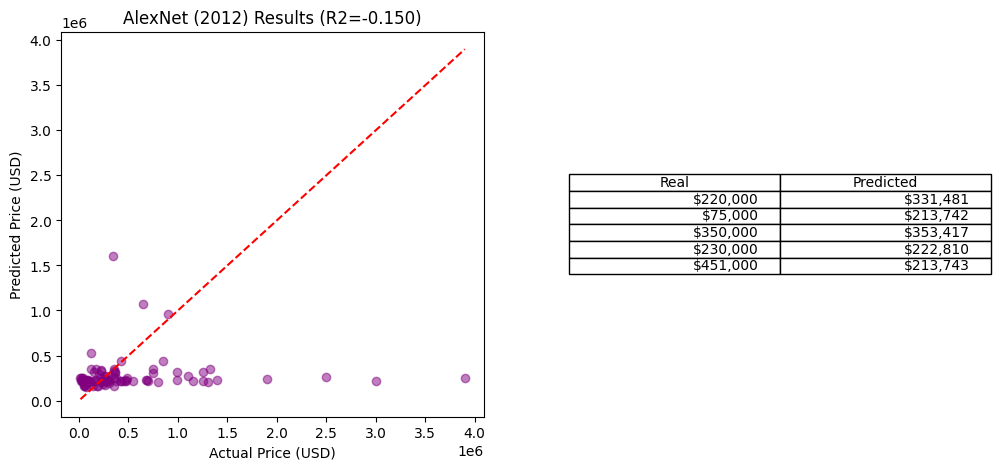


 MODEL: VGG (2014)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 137.6s
    R²: -0.1198
    MAE: $346,583
    MAPE: 147.60%
    Predictions CSV saved: VGG_(2014)_predictions.csv


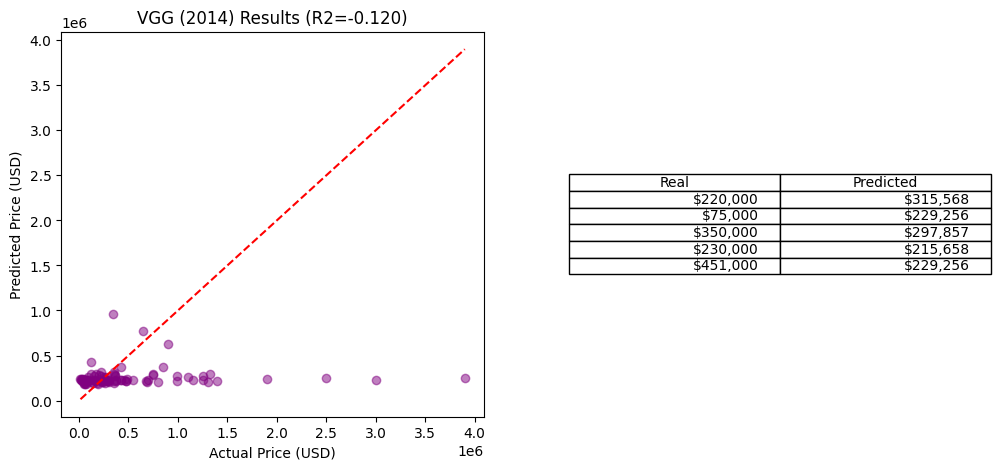


 MODEL: GoogLeNet / Inception-V1 (2014)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 134.1s
    R²: 0.0870
    MAE: $294,210
    MAPE: 96.11%
    Predictions CSV saved: GoogLeNet___Inception-V1_(2014)_predictions.csv


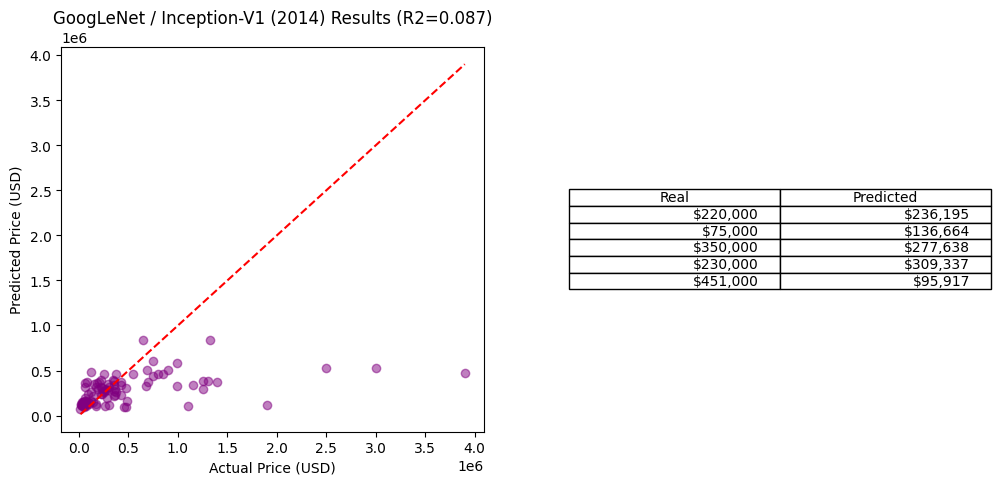


 MODEL: Inception-V3 (2015)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 159.4s
    R²: 0.1893
    MAE: $278,685
    MAPE: 102.96%
    Predictions CSV saved: Inception-V3_(2015)_predictions.csv


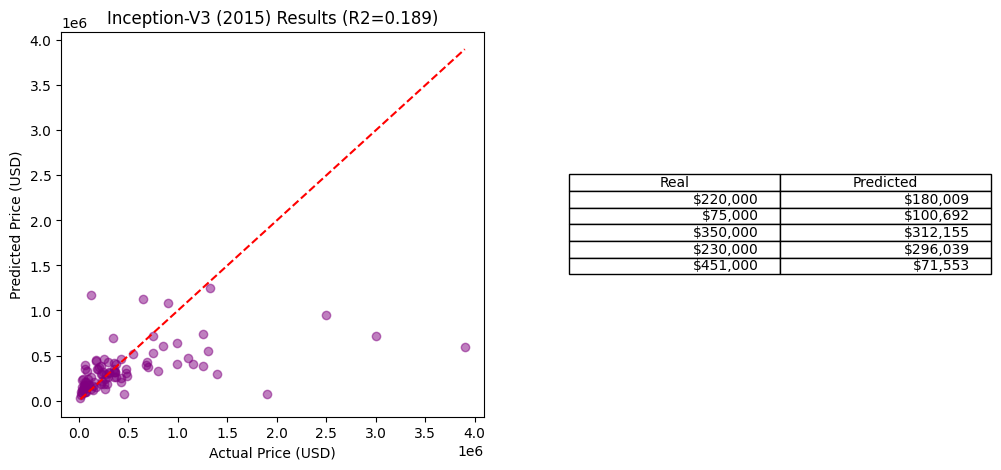


 MODEL: ResNet (2016)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 143.0s
    R²: -0.0142
    MAE: $301,082
    MAPE: 82.17%
    Predictions CSV saved: ResNet_(2016)_predictions.csv


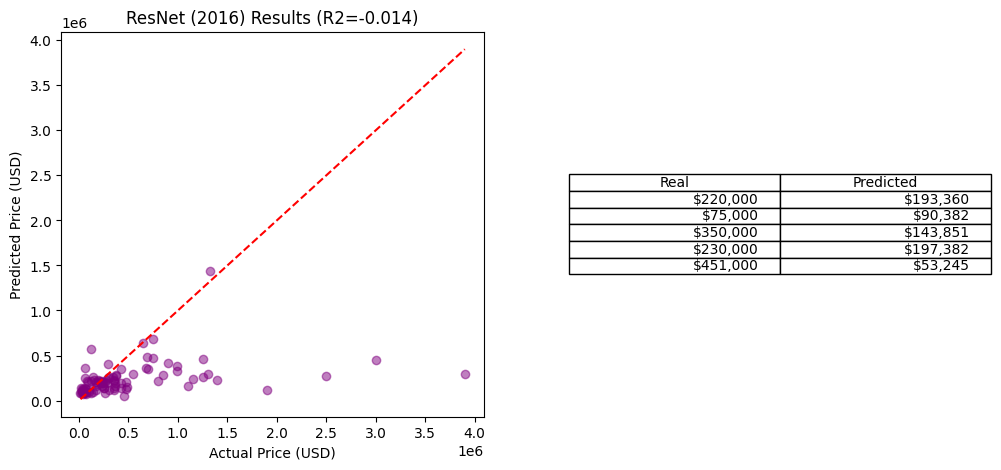

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



 MODEL: DenseNet (2017)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s]
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 146.8s
    R²: 0.0382
    MAE: $318,106
    MAPE: 114.26%
    Predictions CSV saved: DenseNet_(2017)_predictions.csv


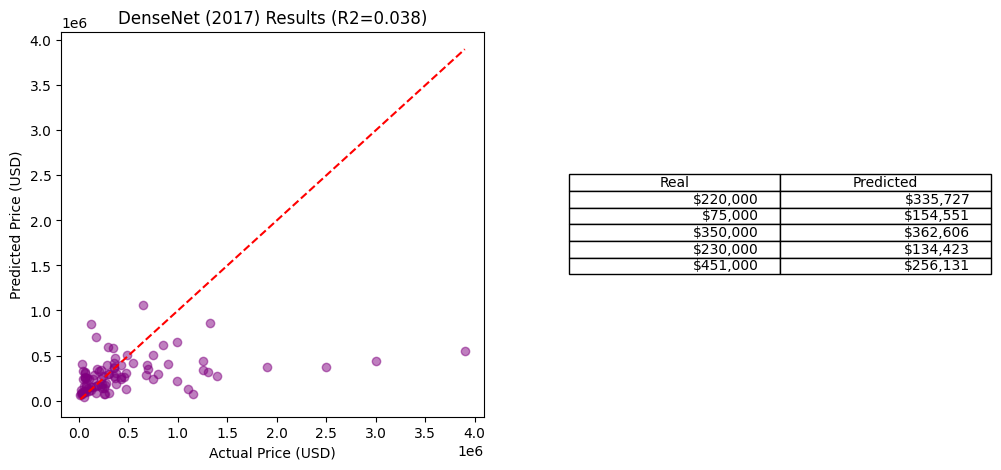

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



 MODEL: MobileNet V2 (2018)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s]
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 166.2s
    R²: 0.0351
    MAE: $292,235
    MAPE: 71.59%
    Predictions CSV saved: MobileNet_V2_(2018)_predictions.csv


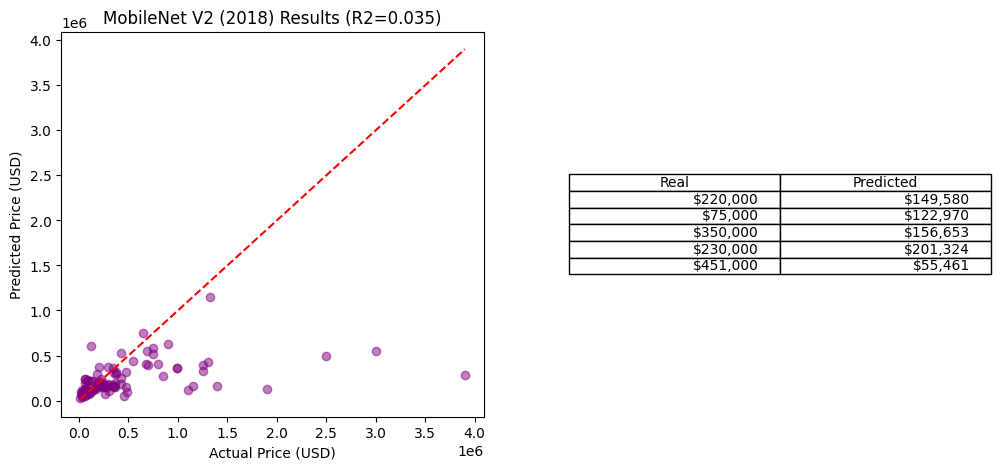


 MODEL: NiN (2013)
 Failed to load backbone for NiN (2013): Unknown model (nin)

 MODEL: ZNet


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 160.6s
    R²: 0.0936
    MAE: $283,780
    MAPE: 95.44%
    Predictions CSV saved: ZNet_predictions.csv


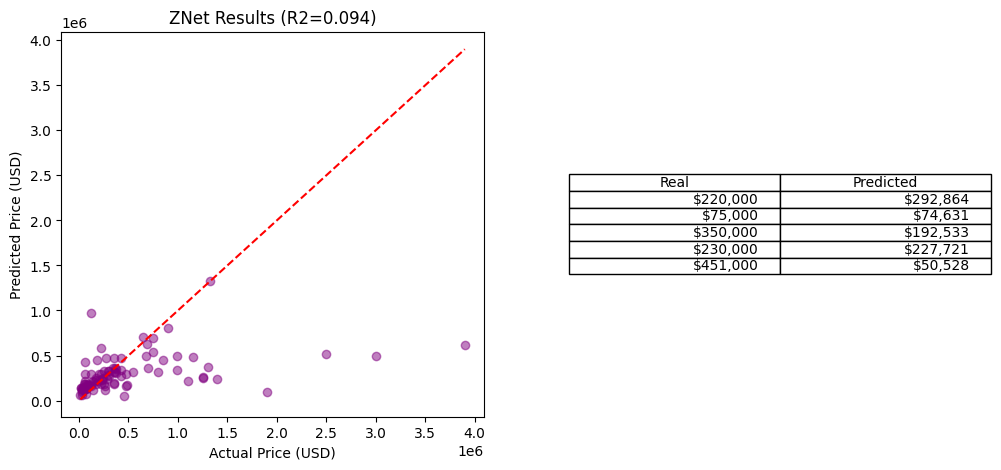


 MODEL: InceptionV4 (2016)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 184.0s
    R²: -0.1959
    MAE: $397,249
    MAPE: 231.07%
    Predictions CSV saved: InceptionV4_(2016)_predictions.csv


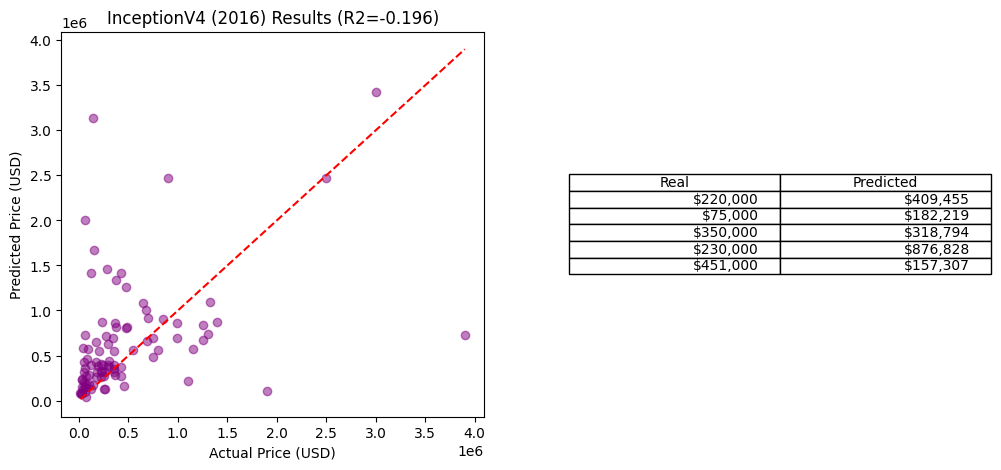


 MODEL: Inception-ResNet-V2 (2016)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 206.6s
    R²: 0.1088
    MAE: $305,233
    MAPE: 110.84%
    Predictions CSV saved: Inception-ResNet-V2_(2016)_predictions.csv


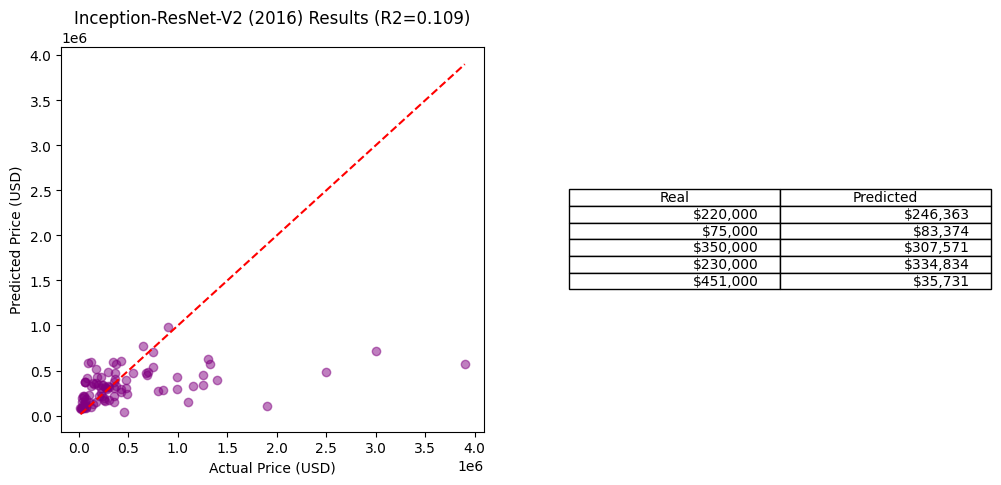


 MODEL: Xception (2017)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 181.8s
    R²: 0.0192
    MAE: $303,179
    MAPE: 79.15%
    Predictions CSV saved: Xception_(2017)_predictions.csv


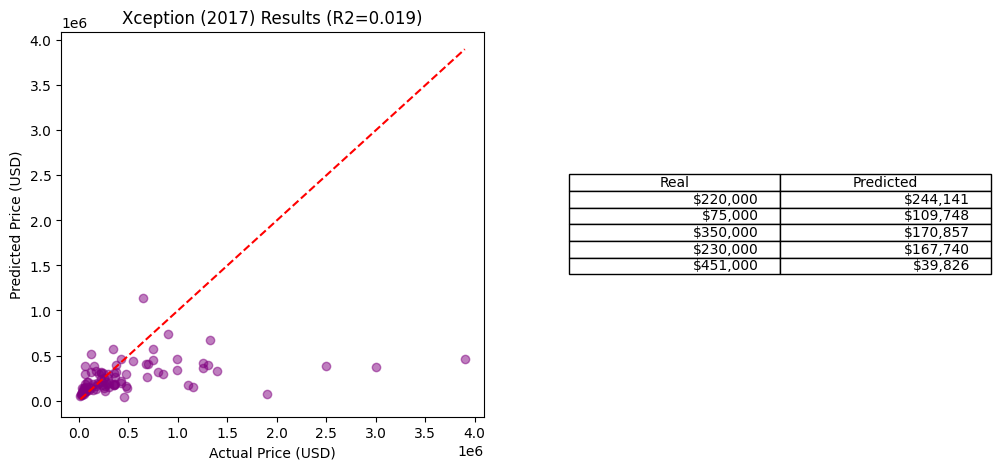


 MODEL: WideResNet (2016)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 157.8s
    R²: 0.0417
    MAE: $295,851
    MAPE: 82.43%
    Predictions CSV saved: WideResNet_(2016)_predictions.csv


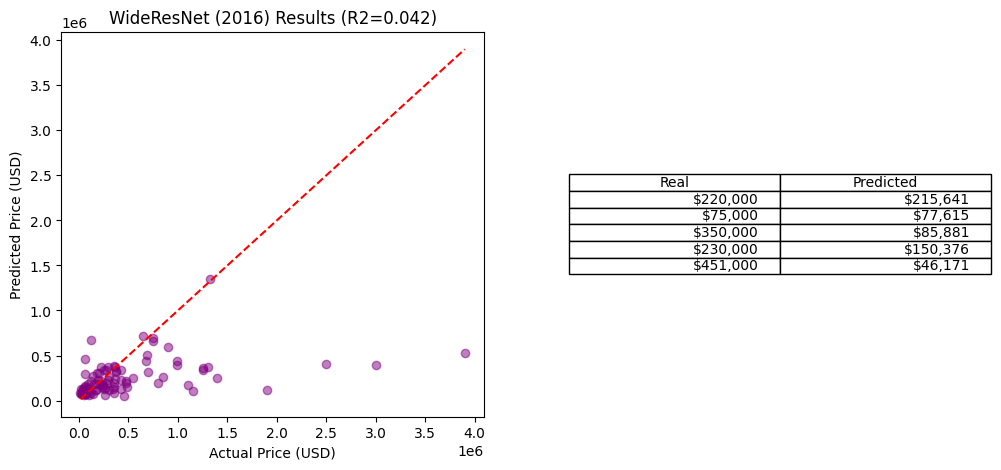


 MODEL: HRNet V2 (2020)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 187.0s
    R²: -0.0077
    MAE: $305,611
    MAPE: 94.59%
    Predictions CSV saved: HRNet_V2_(2020)_predictions.csv


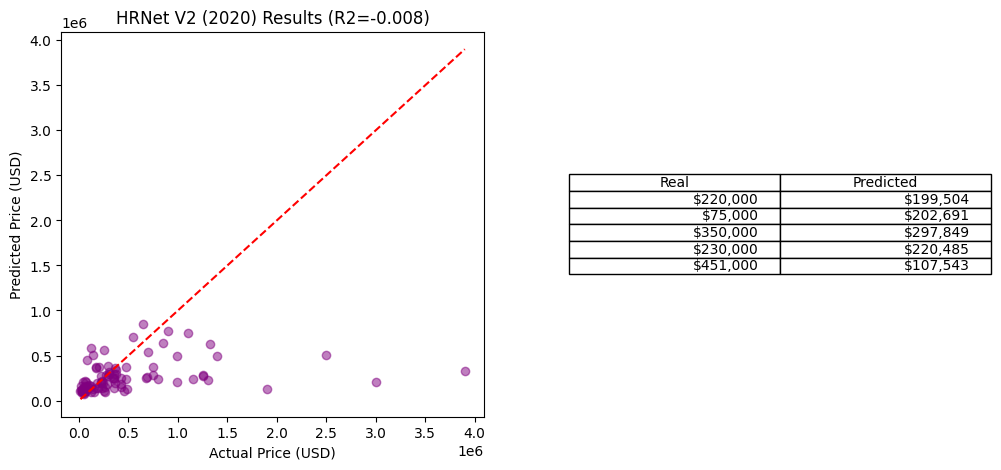


 MODEL: Squeeze and Excitation Networks


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 152.7s
    R²: 0.1104
    MAE: $290,895
    MAPE: 101.31%
    Predictions CSV saved: Squeeze_and_Excitation_Networks_predictions.csv


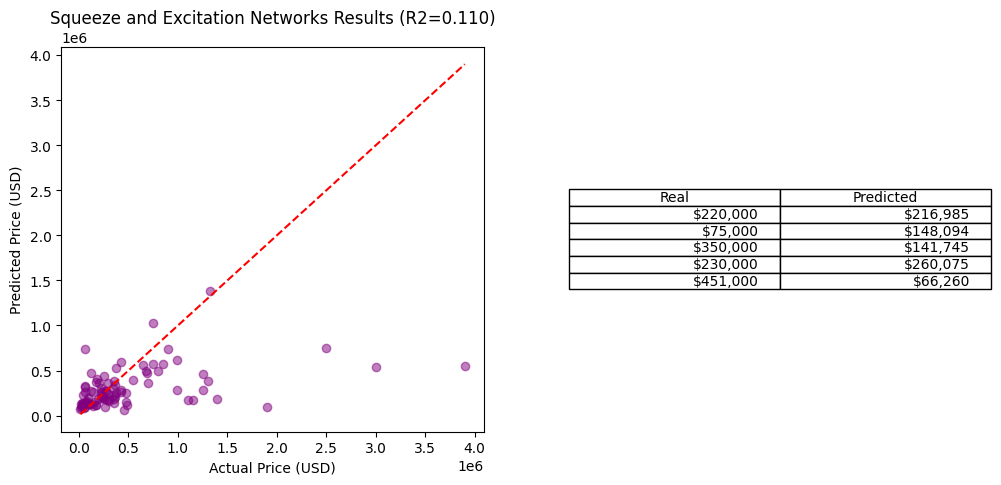


 MODEL: Competitive Squeeze and Excitation Network


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 159.8s
    R²: 0.0599
    MAE: $306,531
    MAPE: 88.51%
    Predictions CSV saved: Competitive_Squeeze_and_Excitation_Network_predictions.csv


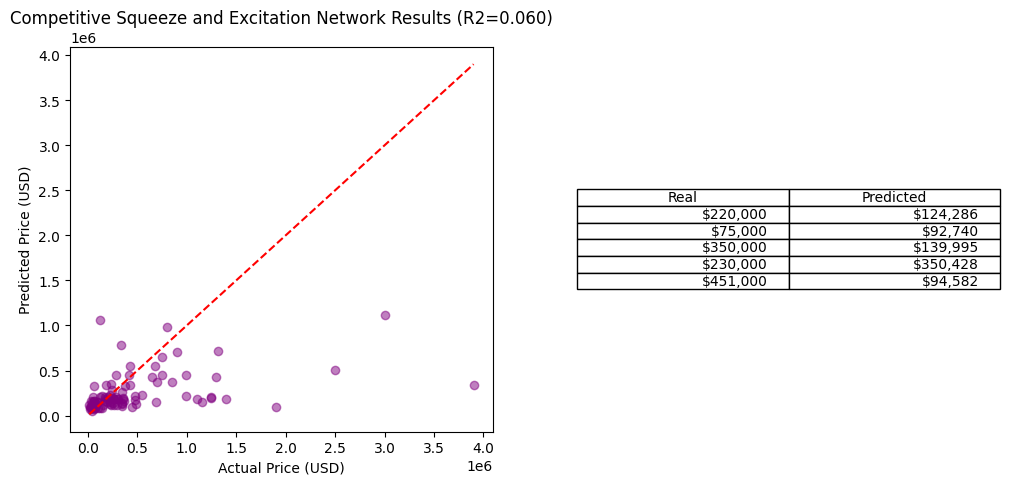


 MODEL: Highway
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 152.3s
    R²: 0.0091
    MAE: $300,910
    MAPE: 70.69%
    Predictions CSV saved: Highway_predictions.csv


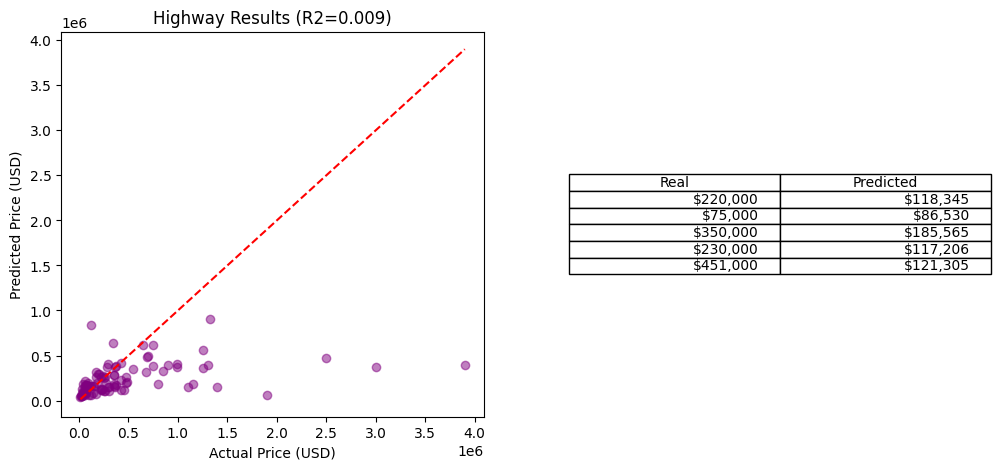


 MODEL: FractalNet


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 141.1s
    R²: -0.0171
    MAE: $305,215
    MAPE: 78.35%
    Predictions CSV saved: FractalNet_predictions.csv


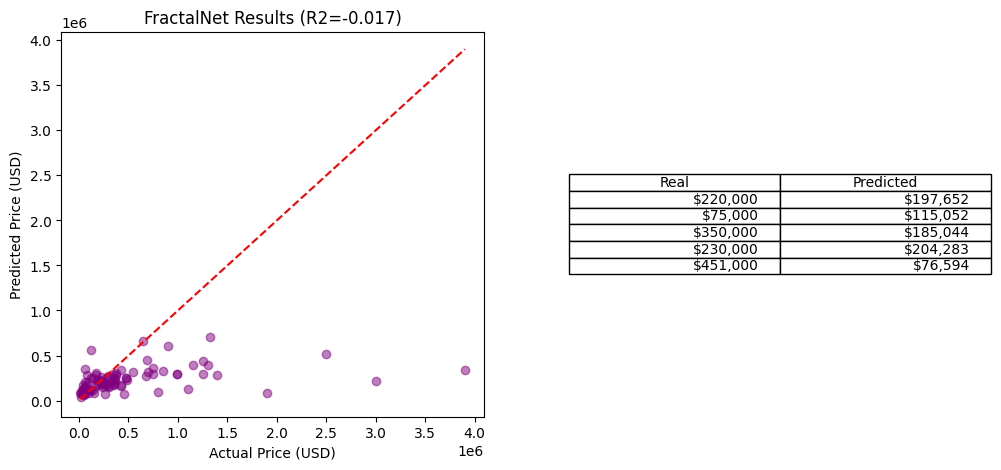


 MODEL: Residual Attention Neural Network


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 160.6s
    R²: -0.0339
    MAE: $329,995
    MAPE: 96.95%
    Predictions CSV saved: Residual_Attention_Neural_Network_predictions.csv


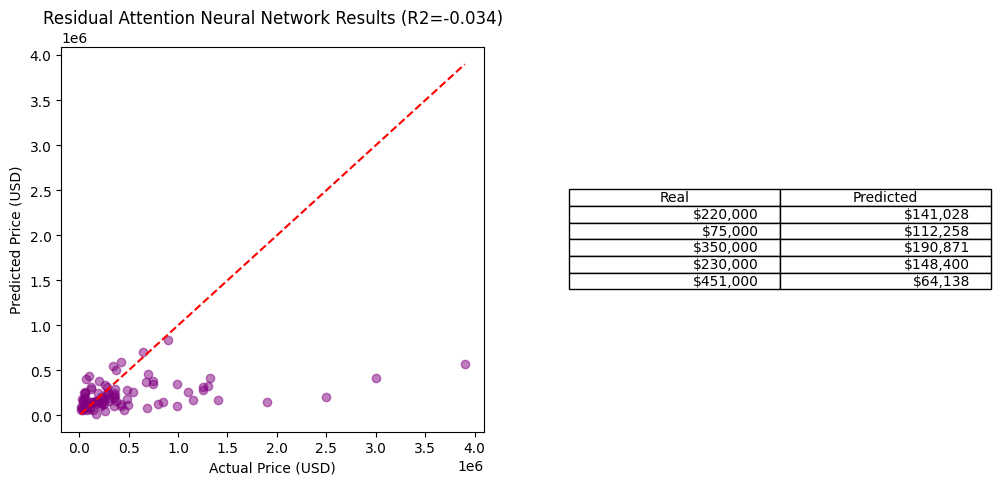


 MODEL: Capsulenet


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2689106062.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Ep 1/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipython-input-2689106062.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 3/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 4/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 5/20 [WARMUP]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 6/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 7/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 8/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 9/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 10/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 11/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 12/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 13/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 14/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 15/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 16/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 17/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 18/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 19/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

Ep 20/20 [FINE-TUNE]:   0%|          | 0/12 [00:00<?, ?it/s]

    Time: 152.0s
    R²: -0.1212
    MAE: $345,065
    MAPE: 139.07%
    Predictions CSV saved: Capsulenet_predictions.csv


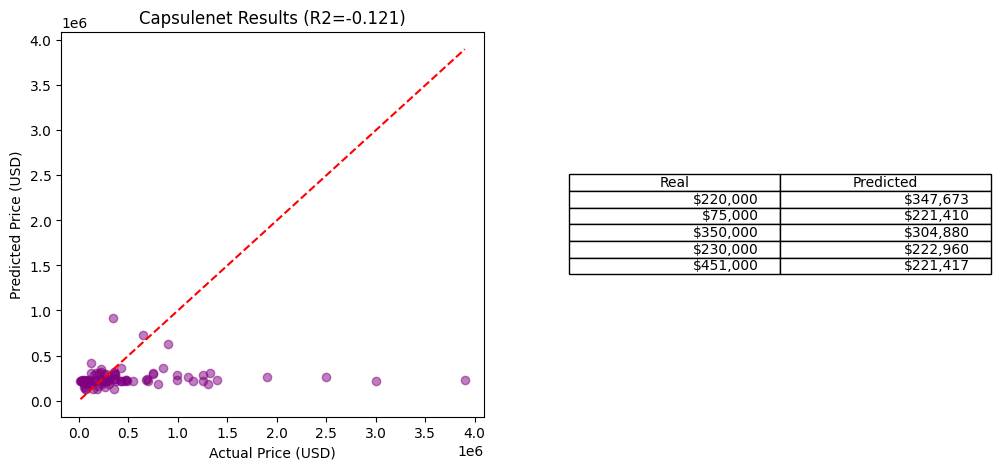


 FINAL RANKING
                                         Model        R2       MAE     MAPE
0                          Inception-V3 (2015)  0.189347  $278,685  102.96%
1              Squeeze and Excitation Networks  0.110423  $290,895  101.31%
2                   Inception-ResNet-V2 (2016)  0.108827  $305,233  110.84%
3                                         ZNet  0.093637  $283,780   95.44%
4              GoogLeNet / Inception-V1 (2014)  0.087011  $294,210   96.11%
5   Competitive Squeeze and Excitation Network  0.059894  $306,531   88.51%
6                            WideResNet (2016)  0.041695  $295,851   82.43%
7                              DenseNet (2017)  0.038225  $318,106  114.26%
8                          MobileNet V2 (2018)  0.035094  $292,235   71.59%
9                              Xception (2017)  0.019191  $303,179   79.15%
10                                     Highway  0.009093  $300,910   70.69%
11                             HRNet V2 (2020) -0.007717  $305,611   94.

In [6]:
# -----------------------------------------------------------------------------
# 5. EXECUTION ENGINE
# -----------------------------------------------------------------------------
def run_benchmark():
    df, feature_cols = load_data(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    models_to_run = [
        'AlexNet (2012)', 'VGG (2014)', 'GoogLeNet / Inception-V1 (2014)',
        'Inception-V3 (2015)', 'ResNet (2016)', 'DenseNet (2017)',
        'MobileNet V2 (2018)', 'NiN (2013)', 'ZNet', 'InceptionV4 (2016)',
        'Inception-ResNet-V2 (2016)', 'Xception (2017)', 'WideResNet (2016)',
        'HRNet V2 (2020)', 'Squeeze and Excitation Networks',
        'Competitive Squeeze and Excitation Network',
        'Highway', 'FractalNet', 'Residual Attention Neural Network',
        'Capsulenet'
    ]

    leaderboard = []

    for model_name in models_to_run:
        print(f"\n MODEL: {model_name}")

        img_size = 299 if model_name in MODELS_REQ_299 else 224

        train_ds = LateFusionDataset(train_df, IMAGE_FOLDER, feature_cols, get_transforms(img_size))
        val_ds = LateFusionDataset(val_df, IMAGE_FOLDER, feature_cols, get_transforms(img_size))

        # data loader: use pin_memory when using CUDA for faster host->device copies
        pin = True if DEVICE.type == 'cuda' else False
        num_workers = 4 if DEVICE.type == 'cuda' else 0
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin)

        backbone = get_backbone(model_name)
        if backbone is None:
            leaderboard.append({'Model': model_name, 'R2': np.nan, 'MAE': np.nan, 'MAPE': np.nan})
            continue

        # Build model using backbone already moved to DEVICE -> ensure LateFusionModel itself on DEVICE
        model = LateFusionModel(backbone, tabular_input_dim=len(feature_cols)).to(DEVICE)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
        use_amp = DEVICE.type == 'cuda'
        scaler = torch.cuda.amp.GradScaler() if use_amp else None

        start_t = time.time()

        for epoch in range(TOTAL_EPOCHS):
            model.train()
            is_warmup = epoch < WARMUP_EPOCHS

            # Freeze/unfreeze cnn params during warmup
            for param in model.cnn.parameters():
                param.requires_grad = not is_warmup

            phase = "WARMUP" if is_warmup else "FINE-TUNE"

            loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{TOTAL_EPOCHS} [{phase}]", leave=False)
            for imgs, tabs, lbls in loop:
                imgs = imgs.to(DEVICE, non_blocking=pin)
                tabs = tabs.to(DEVICE, non_blocking=pin)
                lbls = lbls.to(DEVICE, non_blocking=pin).unsqueeze(1)

                optimizer.zero_grad()
                if use_amp:
                    with torch.cuda.amp.autocast():
                        preds = model(imgs, tabs)
                        loss = criterion(preds, lbls)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    preds = model(imgs, tabs)
                    loss = criterion(preds, lbls)
                    loss.backward()
                    optimizer.step()

                loop.set_postfix(loss=f"{loss.item():.4f}")

        # ---------------- EVALUATION ----------------
        model.eval()
        scaled_actuals = []
        scaled_preds = []

        with torch.no_grad():
            for imgs, tabs, lbls in val_loader:
                imgs = imgs.to(DEVICE, non_blocking=pin)
                tabs = tabs.to(DEVICE, non_blocking=pin)
                out = model(imgs, tabs)
                scaled_preds.extend(out.cpu().numpy().flatten().tolist())
                scaled_actuals.extend(lbls.numpy().flatten().tolist())

        # Inverse scale (log domain)
        log_actual = (np.array(scaled_actuals) * TARGET_STD) + TARGET_MEAN
        log_pred = (np.array(scaled_preds) * TARGET_STD) + TARGET_MEAN

        true_usd = np.expm1(log_actual)
        pred_usd = np.expm1(log_pred)

        # Metrics
        try:
            r2 = r2_score(true_usd, pred_usd)
        except Exception:
            r2 = float('nan')
        try:
            mae = mean_absolute_error(true_usd, pred_usd)
        except Exception:
            mae = float('nan')
        try:
            mape = mean_absolute_percentage_error(true_usd, pred_usd)
        except Exception:
            mape = float('nan')

        print(f"    Time: {time.time() - start_t:.1f}s")
        print(f"    R²: {r2:.4f}")
        print(f"    MAE: ${mae:,.0f}")
        print(f"    MAPE: {mape:.2f}%")

        leaderboard.append({'Model': model_name, 'R2': r2, 'MAE': mae, 'MAPE': mape})

        # ---------------- Save predictions CSV ----------------
        try:
            df_pred = pd.DataFrame({
                'True_USD': true_usd,
                'Predicted_USD': pred_usd
            })
            df_pred['Difference'] = df_pred['Predicted_USD'] - df_pred['True_USD']
            csv_filename = f"{safe_name(model_name)}_predictions.csv"
            df_pred.to_csv(csv_filename, index=False)
            print(f"    Predictions CSV saved: {csv_filename}")
        except Exception as e:
            print(f"    Failed to save predictions CSV for {model_name}: {e}")

        # ---------------- PLOT + SMALL TABLE ----------------
        try:
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            lim = min(len(true_usd), 500)  # plot up to 500 points
            ax[0].scatter(true_usd[:lim], pred_usd[:lim], alpha=0.5, color='purple')
            mn = min(true_usd[:lim].min(), pred_usd[:lim].min())
            mx = max(true_usd[:lim].max(), pred_usd[:lim].max())
            ax[0].plot([mn, mx], [mn, mx], 'r--')
            ax[0].set_xlabel('Actual Price (USD)')
            ax[0].set_ylabel('Predicted Price (USD)')
            ax[0].set_title(f'{model_name} Results (R2={r2:.3f})')

            table_rows = [[f"${x:,.0f}", f"${y:,.0f}"] for x, y in zip(true_usd[:5], pred_usd[:5])]
            ax[1].axis('off')
            ax[1].table(cellText=table_rows, colLabels=['Real', 'Predicted'], loc='center')
            plt.show()
        except Exception as e:
            print(f"    Plotting error for {model_name}: {e}")

        # cleanup
        del model
        torch.cuda.empty_cache()

    # Final leaderboard
    final_df = pd.DataFrame(leaderboard).sort_values(by='R2', ascending=False)
    final_df['MAE'] = final_df['MAE'].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")
    final_df['MAPE'] = final_df['MAPE'].apply(lambda x: f"{x:.2f}%" if pd.notna(x) else "N/A")
    print("\n FINAL RANKING")
    print(final_df.reset_index(drop=True))


if __name__ == "__main__":
    run_benchmark()


The benchmark compares twenty convolution-based architectures on the same Zimbabwe house-price prediction task. Overall performance is weak across the board, with all models showing low explanatory power and high error, indicating that image-only prediction of house prices is highly unreliable for this dataset. The best model, Inception-V3 (2015), reaches an R² of 0.189, meaning it explains only about 19% of price variance. Its mean absolute error remains high at roughly USD 279k, and its percentage error exceeds 100%, showing large deviations between predicted and actual values. Other top-tier models, including SE-Networks and Inception-ResNet-V2, show similarly modest R² values between 0.11 and 0.10 and MAEs above USD 290k.

Most mid-range models (GoogLeNet, WideResNet, DenseNet, MobileNetV2, Xception) score R² values close to zero, indicating almost no predictive contribution beyond a naive baseline. Their MAEs remain in the USD 290k–320k range, and MAPE values suggest unstable predictions across the price distribution. Several architectures—ResNet, FractalNet, Attention-based networks, VGG, CapsNet, AlexNet, and Inception-V4—produce negative R² scores. A negative value means the model performs worse than simply predicting the mean house price for every sample. These models also show higher MAEs, often exceeding USD 330k, and in extreme cases (Inception-V4) reaching nearly USD 400k. The NiN model fails entirely, returning no usable metrics.

The overall pattern indicates that convolutional networks, even deep or modern variants, cannot reliably predict property prices using images alone in this dataset. The inputs likely lack sufficient market-related features such as location, plot size, socio-economic factors, or structural attributes not visible in the images. The extremely high MAPE values, especially in underperforming models, confirm strong instability and poor generalization. The ranking therefore reflects architectural differences, but also highlights a fundamental limitation: house-price prediction requires multimodal data, and relying solely on property images yields low accuracy even with sophisticated models.